### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [203]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sqlalchemy import create_engine

## Individual Data - individual rental listing database

## Import Rent Data - individual rental listing database
# Original data source: https://www.kaggle.com/datasets/austinreese/usa-housing-listings
# Last updated Jan 2020
# Filtered down for 12 largest metros according to: https://worldpopulationreview.com/us-cities

In [204]:
## Import Rent Data
# Read file and display
rent = "Resources/housing_majors.csv"
rent = pd.read_csv(rent)

# Standardize city names
cities_list = rent.drop_duplicates(subset=['region'])
rent = rent.replace([city for city in cities_list['region']], 
                    ['SF/SJ', 'SD', 'JAX', 'CHI', 'NY', 'PHL', 'ATX', 'DFW', 'HOU', 'SA', 'PHX', 'LA'])

# Display data 
rent

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7048692414,https://sfbay.craigslist.org/scz/apa/d/capitol...,SF/SJ,https://sfbay.craigslist.org,1650,apartment,325,1,1.0,0,...,0,0,0,no laundry on site,off-street parking,https://images.craigslist.org/00Y0Y_1S9nzXZ8NF...,Lovely Studio With Small patio for your seren...,36.9771,-121.953,ca
1,7049506190,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1450,apartment,700,1,1.0,0,...,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00G0G_cG4yFLfaAa...,Apartment Details: -1 bedroom 1 bath - Proper...,32.7423,-117.095,ca
2,7043935679,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1700,apartment,700,1,1.0,0,...,0,0,0,laundry on site,NaN,https://images.craigslist.org/00g0g_fjiyS1iI2o...,1 Bedroom with a Great View!!! Minutes to free...,32.7277,-117.165,ca
3,7035359947,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2685,townhouse,1127,2,2.0,1,...,0,0,0,w/d in unit,attached garage,https://images.craigslist.org/00g0g_dA6FtxqdV9...,The life youâve always imagined is at Levant...,32.7958,-117.071,ca
4,7049978012,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1390,apartment,263,0,1.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00v0v_akWNyI1F4d...,THE BARCELONA The perfect pairing of location...,32.7294,-117.162,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26088,7035391481,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2525,apartment,1127,2,2.0,1,...,0,0,0,w/d in unit,attached garage,https://images.craigslist.org/00E0E_bs0T3dPEIH...,"Located near Mission Valley, the townhomes at ...",32.7958,-117.071,ca
26089,7049783450,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2593,apartment,1094,2,2.0,1,...,0,0,0,w/d in unit,NaN,https://images.craigslist.org/01414_kiWespdEZL...,To schedule a tour We now book our tour appoin...,32.8274,-117.138,ca
26090,7049426671,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1300,apartment,490,1,1.0,1,...,1,0,1,laundry on site,off-street parking,https://images.craigslist.org/00B0B_bKWtLiBFGY...,Beautiful Turn-Key 1 Bed/1 Bath is located in ...,32.7560,-117.121,ca
26091,7049461332,https://sandiego.craigslist.org/nsd/apa/d/esco...,SD,https://sandiego.craigslist.org,1646,apartment,812,2,1.0,1,...,0,0,0,NaN,NaN,https://images.craigslist.org/00i0i_lgzbYDbzfP...,Bedrooms: 2 Bathrooms: 1 Square Feet: 812 Int...,33.1435,-117.097,ca


In [205]:
## Filter out unreasonable values and missing lat/long, add price_per_sqfeet, add luandry and parking binaries
rent_low = 100
rent_high = 20000
sqfeet_low = 200
sqfeet_high = 10000
beds_high = 7
baths_high = 7
rent = rent.loc[(rent["price"] >= rent_low) & (rent["price"] <= rent_high) & 
                (rent["sqfeet"] >= sqfeet_low) & (rent["sqfeet"] <= sqfeet_high) &
                (rent["beds"] <= beds_high) & 
                (rent["baths"] <= baths_high), :]
rent = rent[rent.lat.notnull()]
rent = rent[rent.long.notnull()]
rent['price_per_sqfeet'] = rent['price'] / rent['sqfeet']
rent['laundry_in_unit'] = np.where(rent['laundry_options'] == 'w/d in unit', 1, 0)
rent['garage_parking'] = np.where((rent['parking_options'] == 'attached garage') | (rent['parking_options'] == 'carport') |
                                  (rent['parking_options'] == 'detached garage') | (rent['parking_options'] == 'valet parking'), 1, 0)
rent

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,laundry_options,parking_options,image_url,description,lat,long,state,price_per_sqfeet,laundry_in_unit,garage_parking
0,7048692414,https://sfbay.craigslist.org/scz/apa/d/capitol...,SF/SJ,https://sfbay.craigslist.org,1650,apartment,325,1,1.0,0,...,no laundry on site,off-street parking,https://images.craigslist.org/00Y0Y_1S9nzXZ8NF...,Lovely Studio With Small patio for your seren...,36.9771,-121.953,ca,5.076923,0,0
1,7049506190,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1450,apartment,700,1,1.0,0,...,laundry on site,off-street parking,https://images.craigslist.org/00G0G_cG4yFLfaAa...,Apartment Details: -1 bedroom 1 bath - Proper...,32.7423,-117.095,ca,2.071429,0,0
2,7043935679,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1700,apartment,700,1,1.0,0,...,laundry on site,NaN,https://images.craigslist.org/00g0g_fjiyS1iI2o...,1 Bedroom with a Great View!!! Minutes to free...,32.7277,-117.165,ca,2.428571,0,0
3,7035359947,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2685,townhouse,1127,2,2.0,1,...,w/d in unit,attached garage,https://images.craigslist.org/00g0g_dA6FtxqdV9...,The life youâve always imagined is at Levant...,32.7958,-117.071,ca,2.382431,1,1
4,7049978012,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1390,apartment,263,0,1.0,1,...,laundry on site,street parking,https://images.craigslist.org/00v0v_akWNyI1F4d...,THE BARCELONA The perfect pairing of location...,32.7294,-117.162,ca,5.285171,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26088,7035391481,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2525,apartment,1127,2,2.0,1,...,w/d in unit,attached garage,https://images.craigslist.org/00E0E_bs0T3dPEIH...,"Located near Mission Valley, the townhomes at ...",32.7958,-117.071,ca,2.240461,1,1
26089,7049783450,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2593,apartment,1094,2,2.0,1,...,w/d in unit,NaN,https://images.craigslist.org/01414_kiWespdEZL...,To schedule a tour We now book our tour appoin...,32.8274,-117.138,ca,2.370201,1,0
26090,7049426671,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1300,apartment,490,1,1.0,1,...,laundry on site,off-street parking,https://images.craigslist.org/00B0B_bKWtLiBFGY...,Beautiful Turn-Key 1 Bed/1 Bath is located in ...,32.7560,-117.121,ca,2.653061,0,0
26091,7049461332,https://sandiego.craigslist.org/nsd/apa/d/esco...,SD,https://sandiego.craigslist.org,1646,apartment,812,2,1.0,1,...,NaN,NaN,https://images.craigslist.org/00i0i_lgzbYDbzfP...,Bedrooms: 2 Bathrooms: 1 Square Feet: 812 Int...,33.1435,-117.097,ca,2.027094,0,0


In [206]:
## Add database to sql
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html
engine = create_engine('sqlite://', echo = False)
rent.to_sql('rent_data', con = engine)

In [207]:
## Query data from sql (test first record)
engine.execute("SELECT * FROM rent_data").fetchall()[0]

(0, 7048692414, 'https://sfbay.craigslist.org/scz/apa/d/capitola-quaint-studio-walking-distance/7048692414.html', 'SF/SJ', 'https://sfbay.craigslist.org', 1650, 'apartment', 325, 1, 1.0, 0, 0, 0, 0, 0, 0, 'no laundry on site', 'off-street parking', 'https://images.craigslist.org/00Y0Y_1S9nzXZ8NF6_600x450.jpg', 'Lovely Studio  With Small patio for your serene garden setting,  Kitchen, bathroom, living area, storage. Approximately 325 sq ft.   1 1/2 blocks to  ... (67 characters truncated) ... 00 includes all utilities except internet cable and telephone.  Security deposit-$1500.00  No pets please  No smoking  *Please Do Not Disturb Tenant*', 36.9771, -121.953, 'ca', 5.076923076923077, 0, 0)

In [208]:
## Sql data back to pd df
rent = pd.read_sql("SELECT * FROM rent_data", engine.connect())
rent

,index,id,url,region,region_url,price,type,sqfeet,beds,baths,...,laundry_options,parking_options,image_url,description,lat,long,state,price_per_sqfeet,laundry_in_unit,garage_parking
0,0,7048692414,https://sfbay.craigslist.org/scz/apa/d/capitol...,SF/SJ,https://sfbay.craigslist.org,1650,apartment,325,1,1.0,...,no laundry on site,off-street parking,https://images.craigslist.org/00Y0Y_1S9nzXZ8NF...,Lovely Studio With Small patio for your seren...,36.9771,-121.953,ca,5.076923,0,0
1,1,7049506190,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1450,apartment,700,1,1.0,...,laundry on site,off-street parking,https://images.craigslist.org/00G0G_cG4yFLfaAa...,Apartment Details: -1 bedroom 1 bath - Proper...,32.7423,-117.095,ca,2.071429,0,0
2,2,7043935679,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1700,apartment,700,1,1.0,...,laundry on site,None,https://images.craigslist.org/00g0g_fjiyS1iI2o...,1 Bedroom with a Great View!!! Minutes to free...,32.7277,-117.165,ca,2.428571,0,0
3,3,7035359947,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2685,townhouse,1127,2,2.0,...,w/d in unit,attached garage,https://images.craigslist.org/00g0g_dA6FtxqdV9...,The life youâve always imagined is at Levant...,32.7958,-117.071,ca,2.382431,1,1
4,4,7049978012,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1390,apartment,263,0,1.0,...,laundry on site,street parking,https://images.craigslist.org/00v0v_akWNyI1F4d...,THE BARCELONA The perfect pairing of location...,32.7294,-117.162,ca,5.285171,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25590,26088,7035391481,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2525,apartment,1127,2,2.0,...,w/d in unit,attached garage,https://images.craigslist.org/00E0E_bs0T3dPEIH...,"Located near Mission Valley, the townhomes at ...",32.7958,-117.071,ca,2.240461,1,1
25591,26089,7049783450,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,2593,apartment,1094,2,2.0,...,w/d in unit,None,https://images.craigslist.org/01414_kiWespdEZL...,To schedule a tour We now book our tour appoin...,32.8274,-117.138,ca,2.370201,1,0
25592,26090,7049426671,https://sandiego.craigslist.org/csd/apa/d/san-...,SD,https://sandiego.craigslist.org,1300,apartment,490,1,1.0,...,laundry on site,off-street parking,https://images.craigslist.org/00B0B_bKWtLiBFGY...,Beautiful Turn-Key 1 Bed/1 Bath is located in ...,32.7560,-117.121,ca,2.653061,0,0
25593,26091,7049461332,https://sandiego.craigslist.org/nsd/apa/d/esco...,SD,https://sandiego.craigslist.org,1646,apartment,812,2,1.0,...,None,None,https://images.craigslist.org/00i0i_lgzbYDbzfP...,Bedrooms: 2 Bathrooms: 1 Square Feet: 812 Int...,33.1435,-117.097,ca,2.027094,0,0


## Grouped Data - summarized statistics by city

In [209]:
## Final summary dataframe for rent by city
rent_summary = rent.groupby(["region"])

listings = rent_summary['price'].count()
price_mean = rent_summary['price'].mean()
price_median = rent_summary['price'].median()
sqfeet_mean = rent_summary['sqfeet'].mean()
sqfeet_median = rent_summary['sqfeet'].median()
price_per_sqfeet = rent_summary['price_per_sqfeet'].mean()
beds_mean = rent_summary['beds'].mean()
baths_mean = rent_summary['baths'].mean()

rent_grouped = pd.DataFrame({"listings": listings,
                             "price_mean": price_mean,
                             "price_median": price_median,
                             "sq_feet_mean": sqfeet_mean,
                             "sq_feet_median": sqfeet_median,
                             "price_per_sqfeet": price_per_sqfeet,
                             "beds_mean": beds_mean,
                             "baths_mean": baths_mean})
rent_grouped.sort_values(by = 'region')

,listings,price_mean,price_median,sq_feet_mean,sq_feet_median,price_per_sqfeet,beds_mean,baths_mean
region,,,,,,,,
ATX,2418,1379.616212,1275.0,944.507858,850.0,1.572963,1.664185,1.473325
CHI,1483,1723.163857,1500.0,1033.334457,924.0,1.789769,1.749831,1.325691
DFW,2265,1294.348786,1218.0,953.381457,907.0,1.393891,1.642384,1.415894
HOU,1700,1179.226471,1015.0,1018.604706,900.0,1.226971,1.684706,1.500294
JAX,4211,977.447637,935.0,955.769651,920.0,1.056327,1.853716,1.429589
LA,2232,2509.583333,2295.0,919.818100,843.0,2.897057,1.465950,1.426075
NY,723,2643.741355,2400.0,910.092669,850.0,3.164485,1.686030,1.188105
PHL,1833,1620.361702,1495.0,964.278232,900.0,1.842089,1.695035,1.374250
PHX,2036,1208.961198,1180.0,957.498527,900.0,1.351386,1.774558,1.518418


## Import 'Best Cities for Data Scientists' - US News list of Best Cities
# Source: https://www.kaggle.com/datasets/pileatedperch/best-cities-for-data-scientists ('metro_areas' csv)

In [210]:
## Import 'Best Cities for Data Scientists'
# Read file and display
rank = "Resources/metro_areas.csv"
rank = pd.read_csv(rank)

# Filter for major cities
city_list = ['San Francisco, CA', 'San Jose, CA', 'San Diego, CA', 
             'Jacksonville, FL', 'Chicago, IL', 'New York City, NY', 
             'Philadelphia, PA', 'Austin, TX', 'Dallas-Fort Worth, TX', 
             'Houston, TX', 'San Antonio, TX', 'Phoenix, AZ', 
             'Los Angeles, CA']
rank_filter = rank.loc[rank['Metro Area'].isin(city_list)]

# Rename cities to match convention
rank = rank_filter.replace([city for city in rank_filter['Metro Area']], 
                           ['ATX', 'SF/SJ', 'DFW', 'JAX', 'SD', 'SA', 'PHX', 'CHI', 'SF/SJ', 'NY', 'LA', 'HOU', 'PHL'])

# Remove unused columns
rank = rank.drop(columns = ['Est. 2019 Population', 'Average Annual Salary', 'ZORI 2020-06', 'Nomad Score 2019-12-21T17:00Z', 'Nomad Score 2020-06-14T06:30Z', 
                            'Nomad Score 2020-06-14T19:11Z', 'Nomad Score 2020-08-16T06:48Z', 'Nomad Score 2020-08-16T19:13Z', 'U.S. News State Overall Rank'])

# Manually Input missing values
rank.loc[rank['Metro Area'] == 'HOU', 'Avg Annual Rainfall'] = 49.8 #https://en.wikipedia.org/wiki/Climate_of_Houston#:~:text=The%20normal%20annual%20precipitation%20measures,is%20the%20city's%20monsoon%20season.
rank.loc[rank['Metro Area'] == 'HOU', 'Lowest Monthly Avg High Temp'] = 63 #https://en.wikipedia.org/wiki/Climate_of_Houston#:~:text=The%20normal%20annual%20precipitation%20measures,is%20the%20city's%20monsoon%20season.
rank.loc[rank['Metro Area'] == 'HOU', 'Highest Monthly Avg High Temp'] = 95 #https://en.wikipedia.org/wiki/Climate_of_Houston#:~:text=The%20normal%20annual%20precipitation%20measures,is%20the%20city's%20monsoon%20season.
rank.loc[rank['Metro Area'] == 'HOU', 'Violent Crime Rate'] = 625.4 #https://realestate.usnews.com/places/texas/houston/crime
rank.loc[rank['Metro Area'] == 'HOU', 'Property Crime Rate'] = 2585.5 #https://realestate.usnews.com/places/texas/houston/crime
rank.loc[rank['Metro Area'] == 'PHL', 'Avg Annual Rainfall'] = 44.1 #https://en.wikipedia.org/wiki/Philadelphia#Climate
rank.loc[rank['Metro Area'] == 'PHL', 'Lowest Monthly Avg High Temp'] = 41 #https://en.wikipedia.org/wiki/Philadelphia#Climate
rank.loc[rank['Metro Area'] == 'PHL', 'Highest Monthly Avg High Temp'] = 88 #https://en.wikipedia.org/wiki/Philadelphia#Climate
rank.loc[rank['Metro Area'] == 'PHL', 'Violent Crime Rate'] = 344.2 #https://realestate.usnews.com/places/pennsylvania/philadelphia/crime
rank.loc[rank['Metro Area'] == 'PHL', 'Property Crime Rate'] = 1637.8 #https://realestate.usnews.com/places/pennsylvania/philadelphia/crime

# Group by cities in order to combine 'San Francisco & San Jose'
rank = rank.groupby(['Metro Area']).mean()

# Display
rank.sort_values(by = 'Metro Area')

,Avg Annual Rainfall,Lowest Monthly Avg High Temp,Highest Monthly Avg High Temp,Violent Crime Rate,Property Crime Rate,U.S. News Overall Score,Data Scientist Job Postings
Metro Area,,,,,,,
ATX,32.2,62.0,96.0,306.3,2343.40,7.6,36.0
CHI,36.9,31.0,84.0,326.6,1979.30,6.1,99.0
DFW,36.1,56.0,96.0,369.3,1357.40,7.0,42.0
HOU,49.8,63.0,95.0,625.4,2585.50,6.8,23.0
JAX,49.2,65.0,91.0,480.8,2777.60,6.7,3.0
LA,12.8,64.0,75.0,458.0,2363.00,6.1,68.0
NY,49.9,38.0,84.0,329.0,1337.00,6.3,214.0
PHL,44.1,41.0,88.0,344.2,1637.80,6.1,51.0
PHX,8.0,66.0,106.0,470.6,2814.50,6.9,15.0


In [211]:
# Merge with rent_grouped data
rent_grouped = pd.merge(rent_grouped, rank, how="left", left_index = True, right_index = True)
rent_grouped

,listings,price_mean,price_median,sq_feet_mean,sq_feet_median,price_per_sqfeet,beds_mean,baths_mean,Avg Annual Rainfall,Lowest Monthly Avg High Temp,Highest Monthly Avg High Temp,Violent Crime Rate,Property Crime Rate,U.S. News Overall Score,Data Scientist Job Postings
region,,,,,,,,,,,,,,,
ATX,2418,1379.616212,1275.0,944.507858,850.0,1.572963,1.664185,1.473325,32.2,62.0,96.0,306.3,2343.40,7.6,36.0
CHI,1483,1723.163857,1500.0,1033.334457,924.0,1.789769,1.749831,1.325691,36.9,31.0,84.0,326.6,1979.30,6.1,99.0
DFW,2265,1294.348786,1218.0,953.381457,907.0,1.393891,1.642384,1.415894,36.1,56.0,96.0,369.3,1357.40,7.0,42.0
HOU,1700,1179.226471,1015.0,1018.604706,900.0,1.226971,1.684706,1.500294,49.8,63.0,95.0,625.4,2585.50,6.8,23.0
JAX,4211,977.447637,935.0,955.769651,920.0,1.056327,1.853716,1.429589,49.2,65.0,91.0,480.8,2777.60,6.7,3.0
LA,2232,2509.583333,2295.0,919.818100,843.0,2.897057,1.465950,1.426075,12.8,64.0,75.0,458.0,2363.00,6.1,68.0
NY,723,2643.741355,2400.0,910.092669,850.0,3.164485,1.686030,1.188105,49.9,38.0,84.0,329.0,1337.00,6.3,214.0
PHL,1833,1620.361702,1495.0,964.278232,900.0,1.842089,1.695035,1.374250,44.1,41.0,88.0,344.2,1637.80,6.1,51.0
PHX,2036,1208.961198,1180.0,957.498527,900.0,1.351386,1.774558,1.518418,8.0,66.0,106.0,470.6,2814.50,6.9,15.0


## Import income data - Census data for average income by city
# Source: https://www.bea.gov/data/income-saving/personal-income-county-metro-and-other-areas ('Metropolitian Area Table')

In [212]:
## Import income data
income = "Resources/income_data.xlsx"
income = pd.read_excel(income)

# Select relevant rows and columns
income = income.iloc[7:391, [0,2]]

# Rename columns
income.rename(columns = {'Table 2. Per Capita Personal Income, by Metropolitan Area, 2019–2021': "region", 
                         'Unnamed: 2': "Per_Capita_Income_2020"}, inplace = True)

# Filter for major cities
city_list = ['San Francisco-Oakland-Berkeley, CA', 'San Jose-Sunnyvale-Santa Clara, CA', 'San Diego-Chula Vista-Carlsbad, CA', 
             'Jacksonville, FL', 'Chicago-Naperville-Elgin, IL-IN-WI', 'New York-Newark-Jersey City, NY-NJ-PA', 
             'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD', 'Austin-Round Rock-Georgetown, TX', 'Dallas-Fort Worth-Arlington, TX', 
             'Houston-The Woodlands-Sugar Land, TX', 'San Antonio-New Braunfels, TX', 'Phoenix-Mesa-Chandler, AZ', 
             'Los Angeles-Long Beach-Anaheim, CA']
income_filter = income.loc[income['region'].isin(city_list)]

# Standardize city names
income = income_filter.replace([city for city in income_filter['region']], 
                               ['ATX', 'CHI', 'DFW', 'HOU', 'JAX', 'LA', 'NY', 'PHL', 'PHX', 'SA', 'SD', 'SF/SJ', 'SF/SJ'])

# Group by cities in order to combine 'San Francisco & San Jose'
income = income.groupby(['region']).mean()

# Display Data
income.sort_values(by = 'Per_Capita_Income_2020', ascending = False)

,Per_Capita_Income_2020
region,
SF/SJ,115573.5
NY,78727.0
LA,70280.0
PHL,68200.0
SD,67830.0
CHI,66474.0
ATX,64916.0
DFW,61824.0
HOU,61133.0


In [213]:
## Merge Rent and Income data
rent_grouped = pd.merge(rent_grouped, income, how="left", on = "region")

# Display
rent_grouped

,listings,price_mean,price_median,sq_feet_mean,sq_feet_median,price_per_sqfeet,beds_mean,baths_mean,Avg Annual Rainfall,Lowest Monthly Avg High Temp,Highest Monthly Avg High Temp,Violent Crime Rate,Property Crime Rate,U.S. News Overall Score,Data Scientist Job Postings,Per_Capita_Income_2020
region,,,,,,,,,,,,,,,,
ATX,2418,1379.616212,1275.0,944.507858,850.0,1.572963,1.664185,1.473325,32.2,62.0,96.0,306.3,2343.40,7.6,36.0,64916.0
CHI,1483,1723.163857,1500.0,1033.334457,924.0,1.789769,1.749831,1.325691,36.9,31.0,84.0,326.6,1979.30,6.1,99.0,66474.0
DFW,2265,1294.348786,1218.0,953.381457,907.0,1.393891,1.642384,1.415894,36.1,56.0,96.0,369.3,1357.40,7.0,42.0,61824.0
HOU,1700,1179.226471,1015.0,1018.604706,900.0,1.226971,1.684706,1.500294,49.8,63.0,95.0,625.4,2585.50,6.8,23.0,61133.0
JAX,4211,977.447637,935.0,955.769651,920.0,1.056327,1.853716,1.429589,49.2,65.0,91.0,480.8,2777.60,6.7,3.0,55158.0
LA,2232,2509.583333,2295.0,919.818100,843.0,2.897057,1.465950,1.426075,12.8,64.0,75.0,458.0,2363.00,6.1,68.0,70280.0
NY,723,2643.741355,2400.0,910.092669,850.0,3.164485,1.686030,1.188105,49.9,38.0,84.0,329.0,1337.00,6.3,214.0,78727.0
PHL,1833,1620.361702,1495.0,964.278232,900.0,1.842089,1.695035,1.374250,44.1,41.0,88.0,344.2,1637.80,6.1,51.0,68200.0
PHX,2036,1208.961198,1180.0,957.498527,900.0,1.351386,1.774558,1.518418,8.0,66.0,106.0,470.6,2814.50,6.9,15.0,54907.0


## Census File to Load - demographics summarized by city
# Original data source: https://worldpopulationreview.com/us-cities
# Updated for 2020 Census, includes 2023 population

In [214]:
## Census File to Load
# Read file and display
census = "Resources/census_data.csv"
census = pd.read_csv(census)
census.rename(columns = {'name': "region"}, inplace = True)

# Filter for major cities
city_list = ['San Francisco', 'San Jose', 'San Diego', 'Jacksonville', 'Chicago', 'New York City', 'Philadelphia', 'Austin', 
             'Dallas', 'Fort Worth', 'Houston', 'San Antonio', 'Phoenix', 'Los Angeles']
census_filter = census.loc[census['region'].isin(city_list)]

# Standardize city names
census = census_filter.replace([city for city in census_filter['region']], 
                               ['NY', 'LA', 'CHI', 'HOU', 'PHX', 'PHL', 'SA', 'SD', 'DFW', 'SF/SJ', 'ATX', 'JAX', 'DFW', 'SF/SJ'])

# Group by cities in order to combine 'Dallas & Forth Worth' and 'San Francisco & San Jose'
census = census.groupby(['region']).sum()

# Remove unused columns
census = census.drop(columns = ['pop2023', 'pop2022', 'growth', 'geoid', 'ansicode', 'funcstat', 'metroId', 'rank', 'density'])

# Display data
census

,pop2020,pop2010,aland,awater,aland_sqmi,awater_sqmi,intptlat,intptlong
region,,,,,,,,
ATX,961855,790390,828638000,17024700,319.939,6.573,30.3012,-97.7527
CHI,2746388,2695598,588882000,17621500,227.369,6.804,41.8376,-87.6818
DFW,2223294,1939022,1774970000,137481300,685.320,53.082,65.5748,-194.1132
HOU,2304580,2099451,1658090000,81248100,640.194,31.370,29.7857,-95.3888
JAX,949611,821784,1935930000,329458000,747.467,127.204,30.3369,-81.6616
LA,3898747,3792621,1214590000,87468500,468.956,33.772,34.0194,-118.4110
NY,8804190,8175133,777983000,434642000,300.381,167.816,40.6635,-73.9387
PHL,1603797,1526006,347782000,21806100,134.279,8.419,40.0094,-75.1333
PHX,1608139,1445632,1340770000,3236740,517.673,1.250,33.5722,-112.0900


In [215]:
## Merge Datasets on city
rent_grouped = pd.merge(rent_grouped, census, how = "left", on = "region")

# Display
rent_grouped

,listings,price_mean,price_median,sq_feet_mean,sq_feet_median,price_per_sqfeet,beds_mean,baths_mean,Avg Annual Rainfall,Lowest Monthly Avg High Temp,...,Data Scientist Job Postings,Per_Capita_Income_2020,pop2020,pop2010,aland,awater,aland_sqmi,awater_sqmi,intptlat,intptlong
region,,,,,,,,,,,,,,,,,,,,,
ATX,2418,1379.616212,1275.0,944.507858,850.0,1.572963,1.664185,1.473325,32.2,62.0,...,36.0,64916.0,961855,790390,828638000,17024700,319.939,6.573,30.3012,-97.7527
CHI,1483,1723.163857,1500.0,1033.334457,924.0,1.789769,1.749831,1.325691,36.9,31.0,...,99.0,66474.0,2746388,2695598,588882000,17621500,227.369,6.804,41.8376,-87.6818
DFW,2265,1294.348786,1218.0,953.381457,907.0,1.393891,1.642384,1.415894,36.1,56.0,...,42.0,61824.0,2223294,1939022,1774970000,137481300,685.320,53.082,65.5748,-194.1132
HOU,1700,1179.226471,1015.0,1018.604706,900.0,1.226971,1.684706,1.500294,49.8,63.0,...,23.0,61133.0,2304580,2099451,1658090000,81248100,640.194,31.370,29.7857,-95.3888
JAX,4211,977.447637,935.0,955.769651,920.0,1.056327,1.853716,1.429589,49.2,65.0,...,3.0,55158.0,949611,821784,1935930000,329458000,747.467,127.204,30.3369,-81.6616
LA,2232,2509.583333,2295.0,919.818100,843.0,2.897057,1.465950,1.426075,12.8,64.0,...,68.0,70280.0,3898747,3792621,1214590000,87468500,468.956,33.772,34.0194,-118.4110
NY,723,2643.741355,2400.0,910.092669,850.0,3.164485,1.686030,1.188105,49.9,38.0,...,214.0,78727.0,8804190,8175133,777983000,434642000,300.381,167.816,40.6635,-73.9387
PHL,1833,1620.361702,1495.0,964.278232,900.0,1.842089,1.695035,1.374250,44.1,41.0,...,51.0,68200.0,1603797,1526006,347782000,21806100,134.279,8.419,40.0094,-75.1333
PHX,2036,1208.961198,1180.0,957.498527,900.0,1.351386,1.774558,1.518418,8.0,66.0,...,15.0,54907.0,1608139,1445632,1340770000,3236740,517.673,1.250,33.5722,-112.0900


In [216]:
## Add calculated columns
rent_grouped['Density'] = rent_grouped['pop2020'] / rent_grouped['aland_sqmi']
rent_grouped['Growth'] = (rent_grouped['pop2020'] / rent_grouped['pop2010']) - 1
rent_grouped['Listings_per_1k_Capita'] = rent_grouped['listings'] / (rent_grouped['pop2020'] / 1000)
rent_grouped['Listings_per_Density'] = rent_grouped['listings'] / rent_grouped['aland_sqmi']
rent_grouped['Rent_per_Income'] = (rent_grouped['price_mean'] * 12) / rent_grouped['Per_Capita_Income_2020']
rent_grouped['Percent_Water'] = rent_grouped['awater_sqmi'] / rent_grouped['aland_sqmi']

# Display data
rent_grouped

,listings,price_mean,price_median,sq_feet_mean,sq_feet_median,price_per_sqfeet,beds_mean,baths_mean,Avg Annual Rainfall,Lowest Monthly Avg High Temp,...,aland_sqmi,awater_sqmi,intptlat,intptlong,Density,Growth,Listings_per_1k_Capita,Listings_per_Density,Rent_per_Income,Percent_Water
region,,,,,,,,,,,,,,,,,,,,,
ATX,2418,1379.616212,1275.0,944.507858,850.0,1.572963,1.664185,1.473325,32.2,62.0,...,319.939,6.573,30.3012,-97.7527,3006.369964,0.216937,2.513892,7.557691,0.255028,0.020545
CHI,1483,1723.163857,1500.0,1033.334457,924.0,1.789769,1.749831,1.325691,36.9,31.0,...,227.369,6.804,41.8376,-87.6818,12078.990540,0.018842,0.539982,6.522437,0.311068,0.029925
DFW,2265,1294.348786,1218.0,953.381457,907.0,1.393891,1.642384,1.415894,36.1,56.0,...,685.320,53.082,65.5748,-194.1132,3244.169147,0.146606,1.018759,3.305025,0.251232,0.077456
HOU,1700,1179.226471,1015.0,1018.604706,900.0,1.226971,1.684706,1.500294,49.8,63.0,...,640.194,31.370,29.7857,-95.3888,3599.815056,0.097706,0.737662,2.655445,0.231474,0.049001
JAX,4211,977.447637,935.0,955.769651,920.0,1.056327,1.853716,1.429589,49.2,65.0,...,747.467,127.204,30.3369,-81.6616,1270.438695,0.155548,4.434447,5.633694,0.212650,0.170180
LA,2232,2509.583333,2295.0,919.818100,843.0,2.897057,1.465950,1.426075,12.8,64.0,...,468.956,33.772,34.0194,-118.4110,8313.673351,0.027982,0.572492,4.759508,0.428500,0.072015
NY,723,2643.741355,2400.0,910.092669,850.0,3.164485,1.686030,1.188105,49.9,38.0,...,300.381,167.816,40.6635,-73.9387,29310.076203,0.076948,0.082120,2.406943,0.402974,0.558677
PHL,1833,1620.361702,1495.0,964.278232,900.0,1.842089,1.695035,1.374250,44.1,41.0,...,134.279,8.419,40.0094,-75.1333,11943.766337,0.050977,1.142913,13.650683,0.285108,0.062698
PHX,2036,1208.961198,1180.0,957.498527,900.0,1.351386,1.774558,1.518418,8.0,66.0,...,517.673,1.250,33.5722,-112.0900,3106.476482,0.112412,1.266060,3.932985,0.264220,0.002415


## Analysis

In [217]:
# Group by city and create table of summary stats for 'price'
rent_summary['price'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
SF/SJ,2307.0,3074.712614,1460.015907,1000.0,2250.0,2750.0,3500.0,20000.0
NY,723.0,2643.741355,1108.468553,790.0,1900.0,2400.0,3099.0,13125.0
LA,2232.0,2509.583333,1130.463921,510.0,1800.0,2295.0,2910.0,18500.0
SD,2346.0,2254.057545,847.498350,100.0,1746.0,2056.0,2550.0,11995.0
CHI,1483.0,1723.163857,847.958760,450.0,1196.0,1500.0,2000.0,10000.0
PHL,1833.0,1620.361702,679.338637,149.0,1171.0,1495.0,1925.0,5795.0
ATX,2418.0,1379.616212,532.091338,455.0,1053.0,1275.0,1570.0,12975.0
DFW,2265.0,1294.348786,479.278222,116.0,976.0,1218.0,1520.0,6800.0
PHX,2036.0,1208.961198,397.668446,209.0,975.0,1180.0,1370.0,5500.0


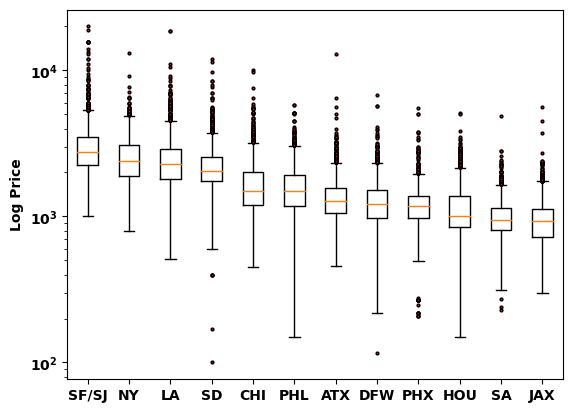

In [218]:
# Boxplot - Log Price
cities = rent_summary['price'].describe().sort_values(by = 'mean', ascending = False).iloc[:, 0]
city_list = [city for city in cities.index]

city0 = rent.loc[rent['region'] == city_list[0]]['price']
city1 = rent.loc[rent['region'] == city_list[1]]['price']
city2 = rent.loc[rent['region'] == city_list[2]]['price']
city3 = rent.loc[rent['region'] == city_list[3]]['price']
city4 = rent.loc[rent['region'] == city_list[4]]['price']
city5 = rent.loc[rent['region'] == city_list[5]]['price']
city6 = rent.loc[rent['region'] == city_list[6]]['price']
city7 = rent.loc[rent['region'] == city_list[7]]['price']
city8 = rent.loc[rent['region'] == city_list[8]]['price']
city9 = rent.loc[rent['region'] == city_list[9]]['price']
city10 = rent.loc[rent['region'] == city_list[10]]['price']
city11 = rent.loc[rent['region'] == city_list[11]]['price']

prices = [city0, city1, city2, city3, city4, city5, city6, city7, city8, city9, city10, city11]

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Log Price')
ax1.boxplot(prices, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'red'})
ax1.set_xticklabels(city_list)
plt.yscale("log")
plt.show()

In [219]:
# Group by city and create table of summary stats for 'sqfeet'
rent_summary['sqfeet'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
CHI,1483.0,1033.334457,481.480698,250.0,710.0,924.0,1200.00,5335.0
HOU,1700.0,1018.604706,508.595897,200.0,700.0,900.0,1140.75,4050.0
PHL,1833.0,964.278232,385.265936,300.0,700.0,900.0,1120.00,3072.0
SF/SJ,2307.0,962.788903,507.728955,200.0,700.0,852.0,1096.00,6500.0
SD,2346.0,958.153026,395.661112,200.0,700.0,900.0,1120.75,5000.0
PHX,2036.0,957.498527,427.230769,240.0,720.0,900.0,1100.00,7290.0
JAX,4211.0,955.769651,307.201847,288.0,753.0,920.0,1105.00,4005.0
DFW,2265.0,953.381457,336.139928,247.0,716.0,907.0,1106.00,4455.0
SA,2041.0,951.847134,398.443805,260.0,675.0,915.0,1100.00,3858.0


In [220]:
# Group by city and create table of summary stats for 'price_per_sqfeet'
rent_summary['price_per_sqfeet'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
SF/SJ,2307.0,3.435870,1.156612,0.466667,2.680557,3.203125,4.034053,8.844444
NY,723.0,3.164485,1.300439,0.791667,2.200000,2.777778,4.182833,7.661996
LA,2232.0,2.897057,0.989113,0.229980,2.255245,2.750000,3.368749,8.780645
SD,2346.0,2.489453,0.710412,0.200000,2.064078,2.360705,2.810680,7.040816
PHL,1833.0,1.842089,0.803709,0.155208,1.326087,1.652334,2.326531,6.074074
CHI,1483.0,1.789769,0.718594,0.357143,1.292686,1.583333,2.194138,5.386100
ATX,2418.0,1.572963,0.527713,0.250370,1.282346,1.477772,1.791020,13.921674
DFW,2265.0,1.393891,0.366915,0.150649,1.182022,1.357590,1.584146,3.238866
PHX,2036.0,1.351386,0.378556,0.138546,1.157407,1.323848,1.501203,4.230769


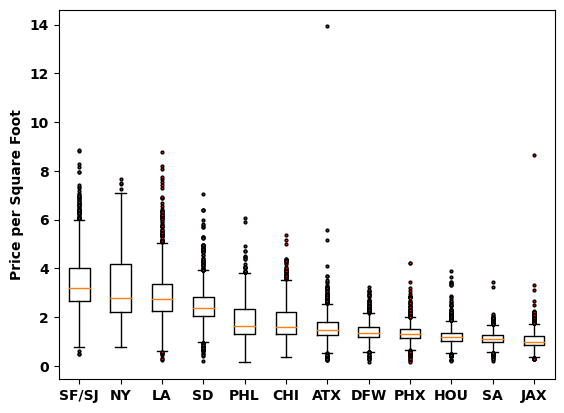

In [221]:
# Boxplot - Price per sqft
cities = rent_summary['price_per_sqfeet'].describe().sort_values(by = 'mean', ascending = False).iloc[:, 0]
city_list = [city for city in cities.index]

city0 = rent.loc[rent['region'] == city_list[0]]['price_per_sqfeet']
city1 = rent.loc[rent['region'] == city_list[1]]['price_per_sqfeet']
city2 = rent.loc[rent['region'] == city_list[2]]['price_per_sqfeet']
city3 = rent.loc[rent['region'] == city_list[3]]['price_per_sqfeet']
city4 = rent.loc[rent['region'] == city_list[4]]['price_per_sqfeet']
city5 = rent.loc[rent['region'] == city_list[5]]['price_per_sqfeet']
city6 = rent.loc[rent['region'] == city_list[6]]['price_per_sqfeet']
city7 = rent.loc[rent['region'] == city_list[7]]['price_per_sqfeet']
city8 = rent.loc[rent['region'] == city_list[8]]['price_per_sqfeet']
city9 = rent.loc[rent['region'] == city_list[9]]['price_per_sqfeet']
city10 = rent.loc[rent['region'] == city_list[10]]['price_per_sqfeet']
city11 = rent.loc[rent['region'] == city_list[11]]['price_per_sqfeet']

prices = [city0, city1, city2, city3, city4, city5, city6, city7, city8, city9, city10, city11]

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Price per Square Foot')
ax1.boxplot(prices, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'red'})
ax1.set_xticklabels(city_list)
#plt.yscale("log")
plt.show()

In [222]:
# Group by city and create table of summary stats for 'beds'
rent_summary['beds'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
JAX,4211.0,1.853716,0.731362,0.0,1.0,2.0,2.0,6.0
PHX,2036.0,1.774558,0.927209,0.0,1.0,2.0,2.0,6.0
SA,2041.0,1.761391,0.912011,0.0,1.0,2.0,2.0,5.0
CHI,1483.0,1.749831,0.939531,0.0,1.0,2.0,2.0,5.0
SD,2346.0,1.738278,0.883708,0.0,1.0,2.0,2.0,5.0
PHL,1833.0,1.695035,0.934692,0.0,1.0,2.0,2.0,6.0
NY,723.0,1.686030,1.045852,0.0,1.0,2.0,2.0,5.0
HOU,1700.0,1.684706,0.838663,0.0,1.0,2.0,2.0,5.0
SF/SJ,2307.0,1.666233,0.937093,0.0,1.0,2.0,2.0,7.0


In [223]:
# Group by city and create table of summary stats for 'baths'
rent_summary['baths'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
SD,2346.0,1.524084,0.596861,0.0,1.0,1.0,2.0,4.5
PHX,2036.0,1.518418,0.565841,0.0,1.0,1.5,2.0,4.0
SA,2041.0,1.504900,0.648509,0.0,1.0,1.0,2.0,5.0
HOU,1700.0,1.500294,0.612192,0.0,1.0,1.0,2.0,4.0
ATX,2418.0,1.473325,0.610395,0.0,1.0,1.0,2.0,4.0
JAX,4211.0,1.429589,0.525337,0.0,1.0,1.0,2.0,4.0
SF/SJ,2307.0,1.429345,0.622811,0.0,1.0,1.0,2.0,5.5
LA,2232.0,1.426075,0.600613,0.0,1.0,1.0,2.0,6.5
DFW,2265.0,1.415894,0.588549,0.0,1.0,1.0,2.0,4.0


In [224]:
# Group by city and create table of % 'dogs_allowed'
rent_summary['dogs_allowed'].describe().sort_values(by = 'mean', ascending = False).iloc[:, [0,1]]

,count,mean
region,,
ATX,2418.0,0.777916
DFW,2265.0,0.750993
PHX,2036.0,0.724951
JAX,4211.0,0.706958
HOU,1700.0,0.646471
SA,2041.0,0.643312
SD,2346.0,0.635550
LA,2232.0,0.622760
CHI,1483.0,0.621713


In [225]:
# Group by city and create table of % 'smoking_allowed'
rent_summary['smoking_allowed'].describe().sort_values(by = 'mean', ascending = False).iloc[:, [0,1]]

,count,mean
region,,
ATX,2418.0,0.889992
PHX,2036.0,0.887033
SA,2041.0,0.880941
HOU,1700.0,0.870000
PHL,1833.0,0.849973
JAX,4211.0,0.844930
DFW,2265.0,0.844592
NY,723.0,0.799447
LA,2232.0,0.689964


In [226]:
# Group by city and create table of % 'electric_vehicle_charge'
rent_summary['electric_vehicle_charge'].describe().sort_values(by = 'mean', ascending = False).iloc[:, [0,1]]

,count,mean
region,,
SF/SJ,2307.0,0.100997
LA,2232.0,0.094982
SD,2346.0,0.071185
HOU,1700.0,0.018235
PHL,1833.0,0.014730
NY,723.0,0.011065
CHI,1483.0,0.010789
ATX,2418.0,0.009098
PHX,2036.0,0.003929


In [227]:
# Group by city and create table of % 'laundry_in_unit'
rent_summary['laundry_in_unit'].describe().sort_values(by = 'mean', ascending = False).iloc[:, [0,1]]

,count,mean
region,,
SF/SJ,2307.0,0.534460
PHL,1833.0,0.484997
PHX,2036.0,0.480845
SD,2346.0,0.474851
CHI,1483.0,0.435604
LA,2232.0,0.357079
HOU,1700.0,0.324706
ATX,2418.0,0.301075
JAX,4211.0,0.228212


In [228]:
# Group by city and create table of % 'garage_parking'
rent_summary['garage_parking'].describe().sort_values(by = 'mean', ascending = False).iloc[:, [0,1]]

,count,mean
region,,
SF/SJ,2307.0,0.655830
LA,2232.0,0.513441
PHX,2036.0,0.508841
SD,2346.0,0.484655
CHI,1483.0,0.350641
HOU,1700.0,0.325294
DFW,2265.0,0.282561
ATX,2418.0,0.203060
NY,723.0,0.188105


The correlation between 'Avg Annual Rainfall' and 'price per sqft' is -0.33


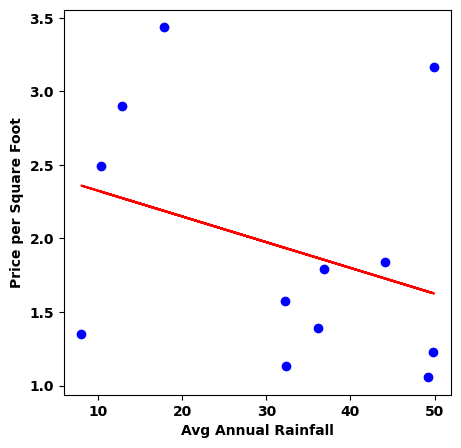

In [229]:
# Scatterplot - Price per Sqft vs Avg Annual Rainfall
# x values
x_vals = rent_grouped['Avg Annual Rainfall']

# y values
y_vals = rent_grouped['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'Avg Annual Rainfall' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Avg Annual Rainfall")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between 'Lowest Monthly Avg High Temp' and 'price per sqft' is -0.25


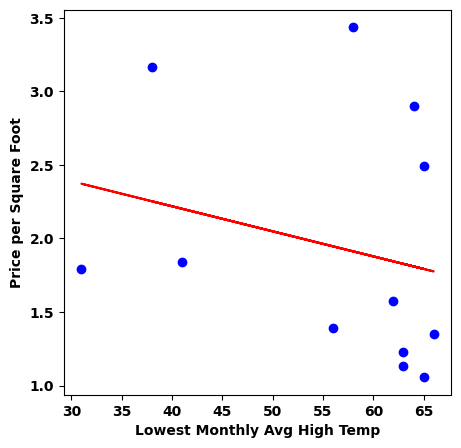

In [230]:
# Scatterplot - Price per Sqft vs Lowest Monthly Avg High Temp
# x values
x_vals = rent_grouped['Lowest Monthly Avg High Temp']

# y values
y_vals = rent_grouped['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'Lowest Monthly Avg High Temp' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Lowest Monthly Avg High Temp")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between 'Highest Monthly Avg High Temp' and 'price per sqft' is -0.79


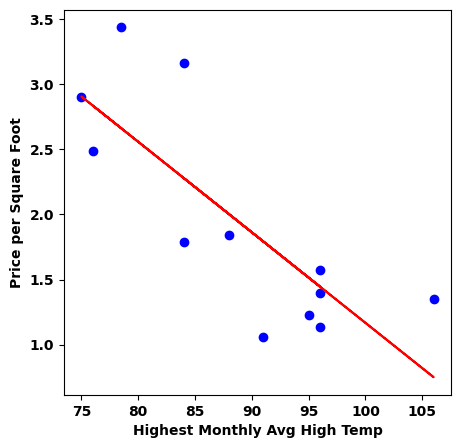

In [231]:
# Scatterplot - Price per Sqft vs Highest Monthly Avg High Temp
# x values
x_vals = rent_grouped['Highest Monthly Avg High Temp']

# y values
y_vals = rent_grouped['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'Highest Monthly Avg High Temp' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Highest Monthly Avg High Temp")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between 'Violent Crime Rate' and 'price per sqft' is -0.42


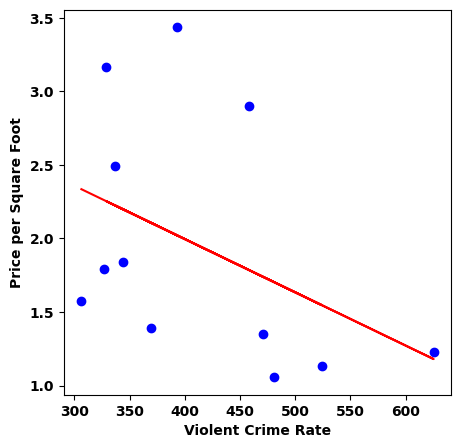

In [232]:
# Scatterplot - Price per Sqft vs Violent Crime Rate
# x values
x_vals = rent_grouped['Violent Crime Rate']

# y values
y_vals = rent_grouped['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'Violent Crime Rate' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Violent Crime Rate")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between 'Price per Square Foot' and 'price per sqft' is -0.46


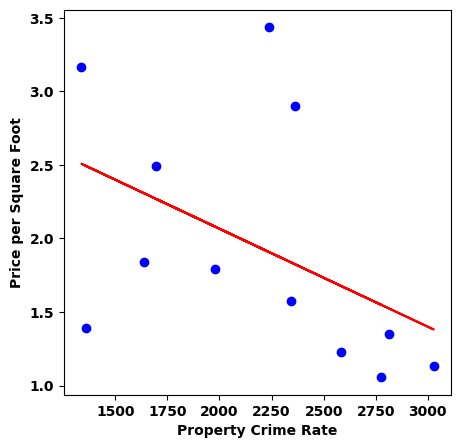

In [233]:
# Scatterplot - Price per Sqft vs Property Crime Rate
# x values
x_vals = rent_grouped['Property Crime Rate']

# y values
y_vals = rent_grouped['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'Price per Square Foot' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Property Crime Rate")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between 'U.S. News Overall Score' and 'price per sqft' is -0.2


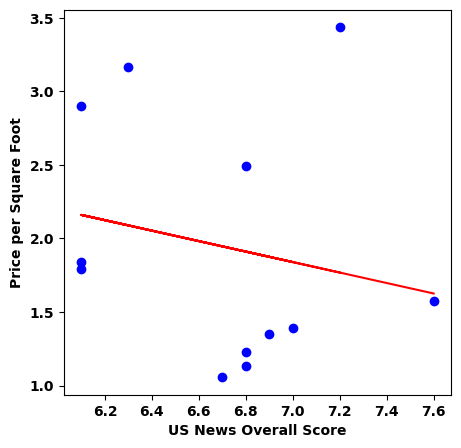

In [234]:
# Scatterplot - Price per Sqft vs U.S. News Overall Score
# x values
x_vals = rent_grouped['U.S. News Overall Score']

# y values
y_vals = rent_grouped['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'U.S. News Overall Score' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("US News Overall Score")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between 'Per_Capita_Income_2020' and 'price per sqft' is 0.83


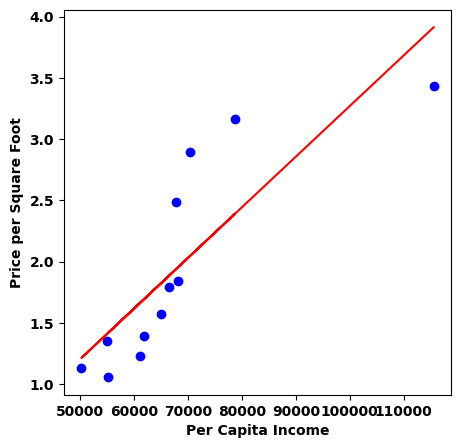

In [235]:
# Scatterplot - Price per Sqft vs Per_Capita_Income_2020
# x values
x_vals = rent_grouped['Per_Capita_Income_2020']

# y values
y_vals = rent_grouped['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'Per_Capita_Income_2020' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Per Capita Income")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between 'density' and 'price per sqft' is 0.62


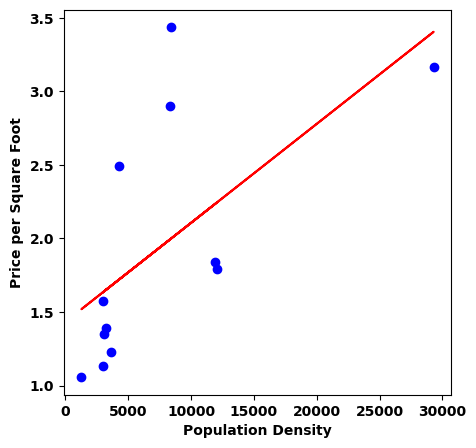

In [236]:
# Scatterplot - Price per Sqft vs Density
# x values
x_vals = rent_grouped['Density']

# y values
y_vals = rent_grouped['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'density' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Population Density")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between 'Listings per 1k Capita' and 'price per sqft' is -0.45


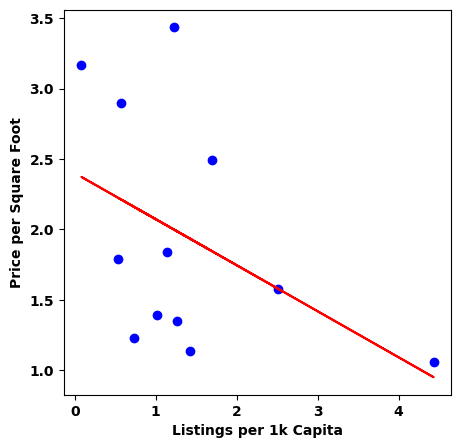

In [237]:
# Scatterplot - Price per Sqft vs Listings per 1k Capita
# x values
x_vals = rent_grouped['Listings_per_1k_Capita']

# y values
y_vals = rent_grouped['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between 'Listings per 1k Capita' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Listings per 1k Capita")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

The correlation between '% water' and 'price per sqft' is 0.76


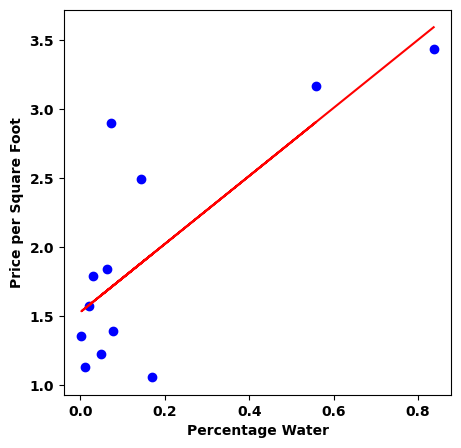

In [238]:
# Scatterplot - Price per Sqft vs % Water
# x values
x_vals = rent_grouped['Percent_Water']

# y values
y_vals = rent_grouped['price_per_sqfeet']

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept

# print correlation coefficient
print(f"The correlation between '% water' and 'price per sqft' is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Percentage Water")
plt.ylabel("Price per Square Foot")
plt.plot(x_vals, regress_values, "r-")
plt.show()

In [239]:
## Potential Findings
# Price/sqft is positively correlated with: Per_Capita_Income_2020 (.83) - higher incomes push up rents
#                                           % of Water (.76) - people pay more to live by water (on coasts)
#                                           Density (.62) - rents are higher in cities that are more dense, these cities have more jobs, attractions

# Price/sqft is negatively correlated with: Highest Monthly Average High Temp (-.79) - people will pay more for more moderate climates
#                                           Property Crime Rate (-.46) - people will pay more for safer cities 
#                                           Listings_per_1k_Capita (-.45) - supply/demand - more listings per person will drive down price
#                                           Violent Crime Rate (-.42) - people will pay more for safer cities
#                                           Average Annual Rainfall (-.33) - people will pay more for less rain
#                                           Lowest Monthly Average High Temp (-.25) - people will pay more for more moderate climates
#                                           US News Overall Score (-.2) - cities with higher scores are actually cheaper / people are less happy in expensive cities

In [240]:
## Write to csv
rent_grouped.to_csv('Resources/rent_grouped.csv')